In [119]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [102]:
df = pd.read_csv('../data/data_world.csv')
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1930-12-08T08:01:02.000Z,23.261,120.277,15.0,6.3,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:52:43.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1930-12-03T18:51:47.000Z,18.233,96.298,10.0,7.4,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:52:43.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1930-12-02T07:01:30.000Z,25.854,98.356,35.0,6.2,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:52:43.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1930-11-28T07:32:56.000Z,18.779,-106.767,15.0,6.3,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:52:43.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1930-11-25T19:02:53.000Z,35.050,139.129,15.0,6.9,mw,NaN,NaN,NaN,NaN,...,2015-05-13T18:52:43.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df = df[["time", "latitude", "longitude", "mag"]]

In [104]:
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%dT%H:%M:%S.%fZ")
df

,time,latitude,longitude,mag
0,1930-12-08 08:01:02.000,23.2610,120.2770,6.3
1,1930-12-03 18:51:47.000,18.2330,96.2980,7.4
2,1930-12-02 07:01:30.000,25.8540,98.3560,6.2
3,1930-11-28 07:32:56.000,18.7790,-106.7670,6.3
4,1930-11-25 19:02:53.000,35.0500,139.1290,6.9
...,...,...,...,...
797041,2018-09-01 01:14:38.230,-30.4830,-177.9279,4.3
797042,2018-09-01 01:07:59.120,-10.7558,124.3621,4.0
797043,2018-09-01 01:00:13.810,-5.5167,147.1735,4.6
797044,2018-09-01 00:27:11.440,46.8819,155.6566,4.3


In [105]:
time_cut = dt.datetime(1973, 1, 1)
df = df[df["time"] > time_cut]
df["energy"] = 10**(1.44*df["mag"]+5.24)
df["label"] = np.where(df["mag"] > 5, 1, 0)

In [106]:
time_split = 30

In [107]:
# group the data into 30 days intervals
df["time"] = df["time"].dt.floor('d')
df["time"] = df["time"] - np.min(df["time"])
df["time"] = df["time"].dt.days // time_split
df["time"] = df["time"].astype(int)

In [108]:
geo_split = 10

In [109]:
df["latitude"] = df["latitude"] // geo_split
df["latitude"] = df["latitude"] + np.abs(np.min(df["latitude"]))

df["longitude"] = df["longitude"] // geo_split
df["longitude"] = df["longitude"] + np.abs(np.min(df["longitude"]))

In [110]:
def filter_regions(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    df_agg = df.groupby(["latitude", "longitude"])["mag"].count().reset_index()
    sum_eq = df_agg["mag"].sum()
    for _, row in df_agg.iterrows():
        if row["mag"] / sum_eq < threshold:
            df = df[(df["latitude"] != row["latitude"]) | (df["longitude"] != row["longitude"])]
    return df

In [111]:
df_agg = df.groupby(["latitude", "longitude", "time"]).agg({"energy": "sum", "label": "sum"}).reset_index()
df_agg

,latitude,longitude,time,energy,label
0,0.0,13.0,268,1.018591e+12,0
1,0.0,22.0,482,3.767038e+11,0
2,0.0,31.0,375,5.248075e+11,0
3,0.0,31.0,473,7.311391e+11,0
4,0.0,33.0,280,2.703958e+11,0
...,...,...,...,...,...
71216,17.0,30.0,487,1.018591e+12,0
71217,17.0,30.0,489,3.767038e+11,0
71218,17.0,30.0,509,7.311391e+11,0
71219,17.0,30.0,538,3.767038e+11,0


In [112]:
df_filter = filter_regions(df.copy(deep=True), 0.005)
df_agg = df_filter.groupby(["latitude", "longitude", "time"]).agg({"energy": "sum", "label": "sum"}).reset_index()
df_agg

,latitude,longitude,time,energy,label
0,3.0,15.0,0,1.782260e+13,2
1,3.0,15.0,1,5.839289e+13,4
2,3.0,15.0,2,3.401240e+13,4
3,3.0,15.0,3,9.108871e+13,3
4,3.0,15.0,4,1.804909e+13,3
...,...,...,...,...,...
28131,15.0,3.0,555,3.625349e+14,5
28132,15.0,3.0,556,5.744135e+12,1
28133,15.0,3.0,557,1.749555e+12,0
28134,15.0,3.0,558,2.127652e+15,3


In [113]:
df_filter = filter_regions(df.copy(deep=True), 0.001)
df_agg = df_filter.groupby(["latitude", "longitude", "time"]).agg({"energy": "sum", "label": "sum"}).reset_index()
df_agg

,latitude,longitude,time,energy,label
0,3.0,15.0,0,1.782260e+13,2
1,3.0,15.0,1,5.839289e+13,4
2,3.0,15.0,2,3.401240e+13,4
3,3.0,15.0,3,9.108871e+13,3
4,3.0,15.0,4,1.804909e+13,3
...,...,...,...,...,...
47536,16.0,18.0,551,1.095600e+12,0
47537,16.0,18.0,552,2.703958e+11,0
47538,16.0,18.0,553,5.256006e+12,0
47539,16.0,18.0,555,2.980928e+13,1


In [123]:
counts = []
for th in np.linspace(0, 0.004, 20):
    df_filter = filter_regions(df.copy(deep=True), th)
    df_agg = df_filter.groupby(["latitude", "longitude", "time"]).agg({"energy": "sum", "label": "sum"}).reset_index()
    counts.append(len(df_agg))

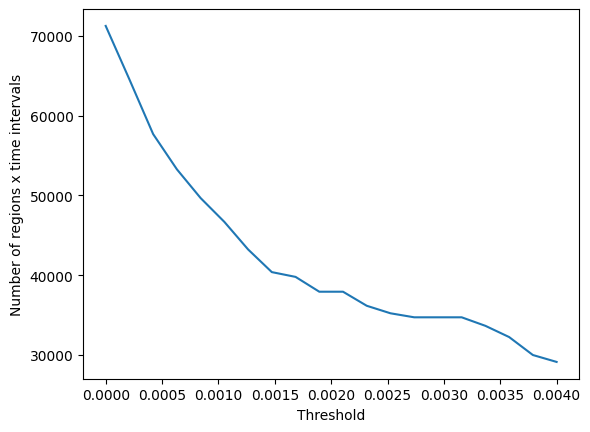

In [124]:
# plot counts
plt.plot(np.linspace(0, 0.004, 20), counts)
plt.xlabel("Threshold")
plt.ylabel("Number of regions x time intervals")
plt.show()